# Seldon deployment of Alibi Outlier detector

Tne objective of this tutorial is to build a "loan approval" classifier equipped with the outliers detector from [alibi-detect](https://github.com/SeldonIO/alibi-detect) package.
The diagram of this tutorial is as follows:

In this tutorial we will follow the following steps:

1) Train and test model to predict loan approvals

2) Train and test outliers detector

3) Containerise and deploy your models

4) Test your your new seldon deployment


### Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* ksonnet v0.13.1+
* kfctl 0.5.1 - Please use this exact version as there are major changes every few months
* Python 3.6+
* Python DEV requirements (we'll install them below)

You can follow this [notebook](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) to setup your cluster.

Let's get started! 🚀🔥 


### Install Python dependencies

In [requirements-dev](https://github.com/SeldonIO/seldon-core/blob/master/examples/outliers/alibi-detect-combiner/requirements-dev.txt) file you will find set of python dependencies required to run this notebook.

In [1]:
!cat requirements-dev.txt

dill==0.3.1
xai==0.0.5

alibi==0.3.2
alibi-detect==0.2.0
seldon_core==1.0

scipy==1.1.0
numpy==1.15.4
scikit-learn==0.20.1


In [ ]:
!pip install -r requirements-dev.txt

## Train and test loanclassifier

We start with training the loanclassifier model by using a prepared python script [train_classifier](https://github.com/SeldonIO/seldon-core/blob/master/examples/outliers/alibi-detect-combiner/train_classifier.py):

In [2]:
!pygmentize train_classifier.py

import alibi
import dill
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


DATA_DIR = "pipeline/loanclassifier"


def load_data(train_size=30000, random_state=0):
    """Load example dataset and split between train and test datasets."""
    print("Loading adult data from alibi.")
    np.random.seed(random_state)

    data = alibi.datasets.fetch_adult()

    # mix input data
    data_perm = np.random.permutation(np.c_[data.data, data.target])
    data.data = data_perm[:, :-1]
    data.target = data_perm[:, -1]

    # perform train / test split
    X_train, y_train = data.data[:train_size, :], data.target[:train_size]
    X_test, y_test = data.data[train_size:, :], data.target[train_size:]

    return data, X_train, y_train, X_test, y_test


def train_preprocessor(data):
    """

In [3]:
!python3 train_classifier.py

Loading adult data from alibi.
Training preprocessor.
Training model.
Serializing preprocessor and model.


This script creates two dill-serialized files `preprocess.dill` and `model.dill` that are used by the `Model` class to make prediction:

In [4]:
!pygmentize pipeline/loanclassifier/Model.py

import logging
import dill
import os


dirname = os.path.dirname(__file__)


class Model:

    def __init__(self, *args, **kwargs):
        """Deserilize preprocessor and model."""
        with open(os.path.join(dirname, "preprocessor.dill"), "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open(os.path.join(dirname, "model.dill"), "rb") as model_f:
            self.clf = dill.load(model_f)

    def predict(self, X, feature_names=[]):
        """Run input X through loanclassifier model."""
        logging.info("Input: " + str(X))

        X_prep = self.preprocessor.transform(X)
        output = self.clf.predict_proba(X_prep)

        logging.info("Output: " + str(output))
        return output


We will in a moment contenrize this Model. You can test how it will work from the notebook:

In [5]:
import sys

sys.path.append("pipeline/loanclassifier")
from Model import Model

model = Model()

Loading adult data from alibi.


,target
precision,0.704545
recall,0.658497
specificity,0.913289
accuracy,0.852401
auc,0.785893
f1,0.680743


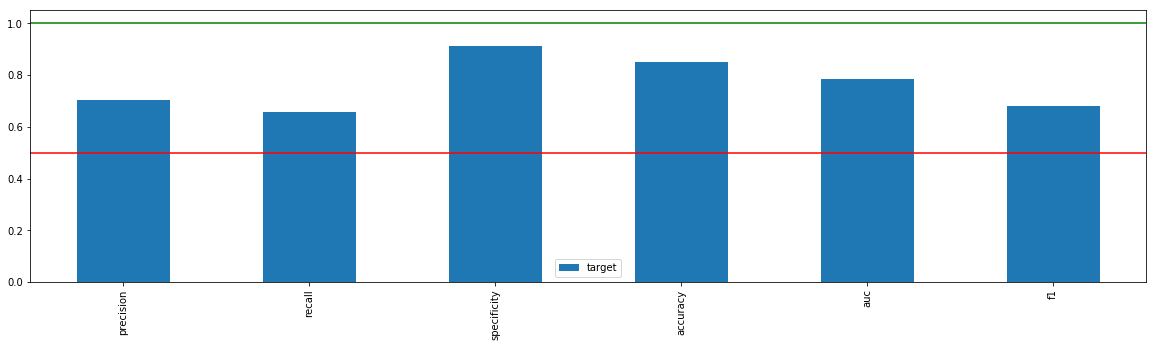

In [6]:
import numpy as np
import xai
from train_classifier import load_data

data, X_train, y_train, X_test, y_test = load_data()
proba = model.predict(X_test)

pred = np.argmax(proba, axis=1)
xai.metrics_plot(y_test, pred)

## Train and test outliers detector

We will now train the outliers detector using another prepared script [train_detector](https://github.com/SeldonIO/seldon-core/blob/master/examples/outliers/alibi-detect-combiner/train_detector.py):

In [7]:
!pygmentize train_detector.py

import dill

import numpy as np

from alibi_detect.od import IForest
from alibi_detect.utils.data import create_outlier_batch
# from alibi_detect.utils.saving import save_detector, load_detector
# from alibi_detect.utils.visualize import plot_instance_score

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from train_classifier import load_data


DATA_DIR = "pipeline/outliersdetector"


def train_preprocessor(data):
    """Train preprocessor."""
    print("Training preprocessor.")

    ordinal_features = [
        n for (n, _) in enumerate(data.feature_names)
        if n not in data.category_map
    ]

    ordinal_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', ordinal_transformer, ordinal_features),
    

In [8]:
!python3 train_detector.py

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
Loading adult data from alibi.
Training preprocessor.
Initialize outlier detector.
Training on normal data.
/home/rskolasinski/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/rskolasinski/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
Train on threshold data.
Serializing preprocessor and model.


In similar fashion to previous Model it will create `dill-serialized` objects used by `Detector` class:

In [9]:
!pygmentize pipeline/outliersdetector/Detector.py

import logging
import dill
import os

import numpy as np


dirname = os.path.dirname(__file__)


class Detector:
    def __init__(self, *args, **kwargs):

        with open(os.path.join(dirname, "preprocessor.dill"), "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open(os.path.join(dirname, "model.dill"), "rb") as model_f:
            self.od = dill.load(model_f)

    def predict(self, X, feature_names=[]):
        logging.info("Input: " + str(X))

        X_prep = self.preprocessor.transform(X)
        output = self.od.predict(X_prep)['data']['is_outlier']

        logging.info("Output: " + str(output))
        return output


You can see how the detector works from this notebook:

In [10]:
import sys

sys.path.append("pipeline/outliersdetector")
from Detector import Detector

detector = Detector()

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [11]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

from alibi_detect.utils.data import create_outlier_batch
from sklearn.metrics import confusion_matrix, f1_score

np.random.seed(1)
outlier_batch = create_outlier_batch(
    data.data, data.target, n_samples=1000, perc_outlier=10
)
X_outlier, y_outlier = outlier_batch.data.astype("float"), outlier_batch.target

In [12]:
y_pred = detector.predict(X_outlier)

F1 score: 0.35365853658536583


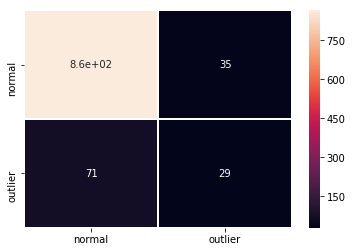

In [13]:
labels = outlier_batch.target_names
f1 = f1_score(y_outlier, y_pred)
print("F1 score: {}".format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=0.5)
plt.show()

## Contenerise your models

Before you can deploy classifier `Model` and outliers `Detector` as part of seldon's graph you have to contenerise them.

We will use the s2i to do so with help of provided [Makefile](https://github.com/SeldonIO/seldon-core/blob/master/examples/outliers/alibi-detect-combiner/Makefile):

In [14]:
!pygmentize Makefile

.ONESHELL:

all: base loanclassifier outliersdetector combiner

base:
	docker build . -t seldon-core-outliers-base:0.1

loanclassifier:
	s2i build pipeline/loanclassifier seldon-core-outliers-base:0.1 loanclassifier:0.1

outliersdetector:
	s2i build pipeline/outliersdetector seldon-core-outliers-base:0.1 outliersdetector:0.1

combiner:
	s2i build pipeline/combiner seldon-core-outliers-base:0.1 combiner:0.1


In [ ]:
!make

or if using Minikube

In [ ]:
!eval $(minikube docker-env) && make

## Deploy your models separately

Now, you can include your newly build containers as part of seldon deployment.

First, we will create two separate deployments: `loanclassifier` and `outliersdetector`.
Each of them will have their own separate endpoint and can be queried independently depending on your needs. 

#### Deploy separate loanclassifier

![outliers-combiner-1](img/outliers-combiner-1.jpg)

In [15]:
!pygmentize pipeline/loanclassifier.yaml

apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier
spec:
  name: loanclassifier
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier:0.1
          name: loanclassifier
          env:
          - name: SELDON_LOG_LEVEL
            value: DEBUG
    graph:
      children: []
      name: loanclassifier
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier
    replicas: 1


In [16]:
!kubectl apply -f pipeline/loanclassifier.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier created


#### Deploy separate outliers detector

![outliers-combiner-2](img/outliers-combiner-2.jpg)

In [17]:
!pygmentize pipeline/outliersdetector.yaml

apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: outliersdetector
spec:
  name: outliersdetector
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: outliersdetector:0.1
          name: outliersdetector
          env:
          - name: SELDON_LOG_LEVEL
            value: DEBUG
    graph:
      children: []
      name: outliersdetector
      type: MODEL
      endpoint:
        type: REST
    name: outliersdetector
    replicas: 1


In [18]:
!kubectl apply -f pipeline/outliersdetector.yaml

seldondeployment.machinelearning.seldon.io/outliersdetector created


#### View newly deployed Kubernetes pods

In [19]:
!kubectl get pods

NAME                                                        READY   STATUS    RESTARTS   AGE
ambassador-69b784f9d5-b444s                                 1/1     Running   1          22h
ambassador-69b784f9d5-zkpbv                                 1/1     Running   3          22h
ambassador-69b784f9d5-zx9w7                                 1/1     Running   3          22h
loanclassifier-loanclassifier-65e0c2e-7449f4d596-55p8t      2/2     Running   0          2m10s
outliersdetector-outliersdetector-1a4e53e-b5cd784df-j56tx   2/2     Running   0          2m8s


#### Test deployed components
**IMPORTANT:** If you are using minikube (instead of docker desktop) you have to forward the port first with:
```
kubectl port-forward svc/ambassador 8003:80
```

In [20]:
import json

from seldon_core.seldon_client import SeldonClient
from seldon_core.utils import get_data_from_proto

In [21]:
to_explain = X_test[:3]
print(to_explain)

[[  46    5    4    2    8    4    4    0 2036    0   60    9]
 [  52    4    0    2    8    4    2    0    0    0   60    9]
 [  21    4    4    1    2    3    4    1    0    0   20    9]]


In [22]:
sc = SeldonClient(
    gateway="ambassador",
    deployment_name="loanclassifier",
    gateway_endpoint="localhost:8003",
    payload_type="ndarray",
    namespace="seldon",
    transport="rest",
)

prediction = sc.predict(data=to_explain)
get_data_from_proto(prediction.response)

array([[0.9, 0.1],
       [0.9, 0.1],
       [1. , 0. ]])

In [23]:
sc = SeldonClient(
    gateway="ambassador",
    deployment_name="outliersdetector",
    gateway_endpoint="localhost:8003",
    payload_type="ndarray",
    namespace="seldon",
    transport="rest",
)

prediction = sc.predict(data=to_explain)
get_data_from_proto(prediction.response)

array([0., 0., 0.])

## Deploy loanclassifier and outliersdetector with combiner

Another possibility is to use slightly more complicated graph with a `combiner` that will
gather outputs from `loanclassifier` and `outliersdetector`.

Please note that `loanclassifier` and `outliersdetector` are part of `loanclassifier-combined` graph and this deployment is independent from previous two.

In this approach there is a single API endpoint that serves both functionalities.

![outliers-combiner-3](img/outliers-combiner-3.jpg)

In [24]:
!pygmentize pipeline/combiner/Combiner.py

import logging
import numpy as np

class Combiner(object):

    def aggregate(self, X, features_names=[]):
        logging.info("Input: " + str(X))
        output = {
            "loanclassifier": X[0].tolist(),
            "outliersdetector": X[1].tolist(),
        }
        logging.info("Output: " + str(output))
        return output


In [25]:
! pygmentize pipeline/combiner.yaml

apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier-combined
spec:
  annotations:
    project_name: Iris classification
  name: loanclassifier-combined
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier:0.1
          name: loanclassifier
          env:
          - name: SELDON_LOG_LEVEL
            value: DEBUG
        - image: outliersdetector:0.1
          name: outliersdetector
          env:
          - name: SELDON_LOG_LEVEL
            value: DEBUG
        - image: combiner:0.1
          name: combiner
          env:
          - name: SELDON_LOG_LEVEL
            value: DEBUG
    graph:
      children:
      - children: []
        name: loanclassifier
        type: MODEL
        endpoint:
          type: REST
      - children: []
        name: outliersdetector
        type: MODEL
        endpoint:
          type: REST
      endpoint:
        type: REST
     

In [26]:
!kubectl apply -f pipeline/combiner.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier-combined created


In [28]:
!kubectl get pods

NAME                                                              READY   STATUS    RESTARTS   AGE
ambassador-69b784f9d5-b444s                                       1/1     Running   1          22h
ambassador-69b784f9d5-zkpbv                                       1/1     Running   3          22h
ambassador-69b784f9d5-zx9w7                                       1/1     Running   3          22h
loanclassifier-combined-combiner-graph-f931ba8-6b8645f8f9-q99nr   4/4     Running   0          28s
loanclassifier-loanclassifier-65e0c2e-7449f4d596-55p8t            2/2     Running   0          2m50s
outliersdetector-outliersdetector-1a4e53e-b5cd784df-j56tx         2/2     Running   0          2m48s


In [29]:
sc = SeldonClient(
    gateway="ambassador",
    deployment_name="loanclassifier-combined",
    gateway_endpoint="localhost:8003",
    payload_type="ndarray",
    namespace="seldon",
    transport="rest",
)

prediction = sc.predict(data=to_explain)
output = get_data_from_proto(prediction.response)

In [30]:
prediction.response

meta {
  puid: "5ef3jd2oumacs4ig0ldr7ads2a"
  routing {
    key: "combiner"
    value: -1
  }
  requestPath {
    key: "combiner"
    value: "combiner:0.1"
  }
  requestPath {
    key: "loanclassifier"
    value: "loanclassifier:0.1"
  }
  requestPath {
    key: "outliersdetector"
    value: "outliersdetector:0.1"
  }
}
jsonData {
  struct_value {
    fields {
      key: "loanclassifier"
      value {
        list_value {
          values {
            list_value {
              values {
                number_value: 0.9
              }
              values {
                number_value: 0.1
              }
            }
          }
          values {
            list_value {
              values {
                number_value: 0.9
              }
              values {
                number_value: 0.1
              }
            }
          }
          values {
            list_value {
              values {
                number_value: 1.0
              }
              values {
  

In [31]:
output["loanclassifier"]

[[0.9, 0.1], [0.9, 0.1], [1.0, 0.0]]

In [32]:
output["outliersdetector"]

[0.0, 0.0, 0.0]